#  Sonification of geophysical data via time-frequency analysis

In this workshop, we are focusing on the augmented representation of geophysical time series using the audio dimension. We apply a time-frequency tranformation to extract musical notes that can be easily reproduced and applied to a different dataset.

The information theory suggests that by encoding information in multiple dimensions simultaneously we must be able to transmit more information than if the information was encoded unidimensionally. Sonification is the process of transforming data to an attribute of sound. Doing this we try to reflect the properties of the input data in audio track. A common technique for sonification is parameter mapping which requires a mapping of the data to the element of sound (for example, scaled energy/frequency of electrons at different atomic orbitals). By simultaneously looking and listening to the data we can get a deeeper understanding the internal structure of the data. 


### Resources:


- [Gallery of sonification projects](https://sonification.design/)

- [Web app to convert time-series to sound](sonification.highcharts.com)

- books and papers

[Hermann et al. (2011) The Sonification Handbook, Logos Publishing House](https://sonification.de/handbook/)

[Worrall, D. (2019) Sonification Design: From Data to Intelligible Soundfields, Springer](https://link.springer.com/book/10.1007/978-3-030-01497-1)

[Dell'Aversana et al. (2016) Sonification of geophysical data through time–frequency analysis: theory and applications, Geophysical Prospecting](https://onlinelibrary.wiley.com/doi/full/10.1111/1365-2478.12402)  



## Introduction to Time-Frequency Analysis


Time-frequency analysis is essential in geophysical data processing, as it allows the examination of spectral content as it changes over time. Such an analysis is crucial for signals that are non-stationary, where frequency content varies temporally, which is common in geophysical data. Time-frequency analysis has diverse applications in geophysics, including seismic, electromagnetic, and others. It enables pattern identification, anomaly detection, and a deeper understanding of complex signal behaviors, which are crucial for interpretation in exploration and monitoring.

Fourier Transform is a standard tool for signal analysis, but it lacks time-localized frequency information. The Short-Time Fourier Transform (STFT) resolves this by segmenting the signal into smaller sections and applying the Fourier Transform to each segment, yielding a time-dependent frequency spectrum.

The forward STFT is given by:
\begin{equation} 
STFT\{x(t)\}(\tau, \omega) = \int_{-\infty}^{+\infty} x(t) · w(t-\tau) · e^{-j\omega t} dt
\end{equation}

where $x(t) $ is the signal, $ w(t) $ is the window function, and $\tau$ and $\omega$ represent time and frequency, respectively.

Discrete form $X(m, \omega) = \sum_{n=-\infty}^{\infty} x(n) w(n-m) e^{-j\omega n}
$

The Hamming window, a commonly used window function, is defined as:
\begin{equation} 
w(n) = 0.54 - 0.46 \cos\left(\frac{2πn}{N-1}\right)
\end{equation}

for $ 0 \le n \le N-1 $, where $ N $ is the window length.

The inverse short-time Fourier transform is computed by taking the IFFT of each DFT vector of the STFT and overlap-adding the inverted signals.

\begin{equation} 
x(t) = \int_{-\infty}^{+\infty} STFT\{x(t)\} · w(t-\tau) · e^{j\omega t} d\omega
\end{equation}
Discrete form 
$x(n) = \frac{1}{\sum_{m=-\infty}^{\infty} w^2(n-m)} \sum_{m=-\infty}^{\infty} \int_{-\pi}^{\pi} X(m, \omega) w(n-m) e^{j\omega n} d\omega$

In this workshop, we will apply STFT to identify instantaneous (within the window) frequencies of the signal which can be converted to MIDI notes, saved as an audio files and played as sound track - the process called "sonification". This approach was found to be useful, openning a new domain of data interpretation. The method is described in 


## Import data

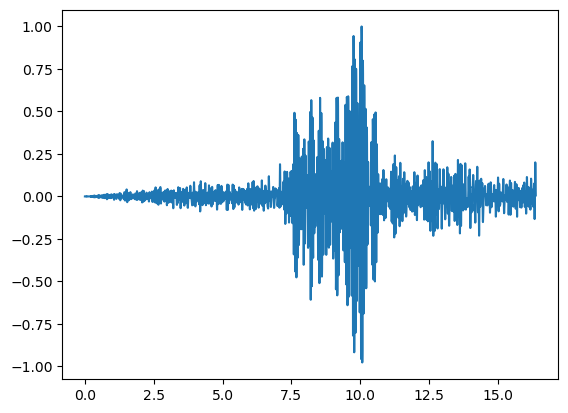

In [22]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
# Load the data from a .mat file
X = np.loadtxt('data')
# Extract time vector and data vector
dt = 4e-3
nt = np.size(X)
t = np.arange(0,nt*dt,dt)
Fs = 1 / dt

plt.plot(t,X)
plt.show()

## Data Processing

We first apply bandbass filtering to the seismic trace to extract useful signal and remove noise. After that, we apply STFT in a window moving through the time. Then, we identify the frequency corresponding to the maximum value of the 2D amplitude spectrum at each time slice using the smoothed amplitude spectrum. 

In [23]:
import numpy as np
from scipy.signal import butter, filtfilt, spectrogram
from scipy.ndimage import median_filter

# Bandpass filtering to remove noise
freq_min = 4  # Low frequency for filtering 
freq_max = 40  # High frequency for filtering 
f_Nyquist = Fs / 2  # Nyquist frequency - maximum frequency that can be measured

# Setup Butterworth filter
B, A = butter(6, [freq_min / f_Nyquist, freq_max / f_Nyquist], btype='band')

# Apply filter (make sure that it's zero phase - no shifts of signal)
# Also, handle NaN values by ignoring them in mean calculation
X_filtered = filtfilt(B, A, X - np.nanmean(X))
# Note, filtfilt applies the filter forward and backward, 
# ensuring a zero-phase response, which is important for 
# signal analysis where phase information is crucial.
X_filtered = X_filtered / np.max(np.abs(X_filtered))  # Normalize signal to 1



## Convert timeseries to audio WAV (Waveform Audio File Format) 

-  audio file format for storing waveform data. Essentially, it's a digital representation of soun;
- raw, uncompressed audio data. This data represent the actual sound waves;
- WAV files are large, detailed information about the sound wave;
- used for high-quality audio recordings like music tracks, sound effects, and voice recordings;
- widely compatible with different audio playback and editing software;
- File name for the output WAV file..file



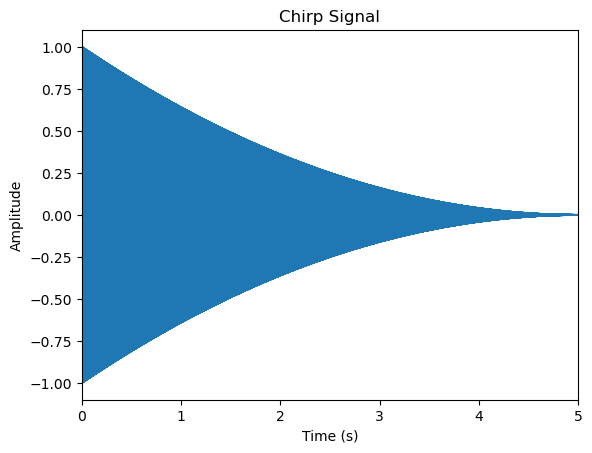

In [36]:
import numpy as np
from scipy.signal import chirp
import sounddevice as sd
import matplotlib.pyplot as plt

# Parameters
Fs = 44100  # Sampling frequency in Hz
T = 5       # Duration of the signal in seconds
f0 = 500    # Start frequency of the chirp (500 Hz)
f1 = 3000   # End frequency of the chirp (3000 Hz)

# Time vector
t = np.arange(0, T, 1/Fs)

# Generate the chirp signal
x = (1 - t/T)**2 * chirp(t, f0, T, f1)

# Play the chirp signal
sd.play(x, Fs)
sd.wait()  # Wait until the sound is done playing

# Plot the chirp signal
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Chirp Signal')
plt.axis([0, T, -1.1, 1.1])  # Set axis limits for better visualization
plt.show()


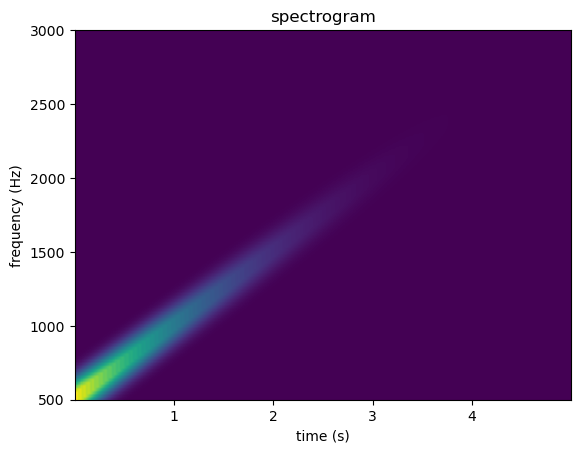

In [42]:

# Compute the spectrogram using the short-time Fourier transform
window = 256  # Window length for STFT
noverlap = 0.5*window  # Overlap between windows in STFT
nfft = 2048  # Number of DFT points
# Compute the spectrogram using the short-time Fourier transform
# The signal is divided into segments "window" with "noverlap" points overlap,
# and each segment is windowed with a Hamming window.
# "nfft" is the number of frequency points used to calculate the discrete Fourier transform
frequencies, times, Sxx = spectrogram(x, fs=Fs, window='hamming', nperseg=window, noverlap=noverlap, nfft=nfft)

# Get amplitude spectrum and smooth the spectrogram using a median filter
Sxx = median_filter(np.abs(Sxx), size=(7, 7))

# Find the peak frequency in each time slice
peak_indices = np.argmax(Sxx, axis=0)
peak_frequencies = frequencies[peak_indices]  # Find peak frequency for each time slice

plt.imshow(Sxx, aspect='auto',origin='lower', extent=[times.min(), times.max(), frequencies.min(), frequencies.max()])
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.title('spectrogram')
plt.ylim([f0, f1])
plt.show()


## Time-frequency spectrogram using wavelet transform

Wavelet transform is another method offering variable window size, thus providing better resolution in both time and frequency domains. This is especially useful for signals with transient features or rapid changes.



### Forward Continuous Wavelet Transform (CWT)

The Continuous Wavelet Transform (CWT) of a function $x(t)$ using the wavelet $\psi(t)$ is defined as:

\begin{equation}
X(a, b) = \frac{1}{\sqrt{|a|}} \int_{-\infty}^{\infty} x(t) \, \psi^*\left(\frac{t - b}{a}\right) \, dt
\end{equation}

where:
 - $X(a, b)$ is the wavelet coefficient at scale $a$ and translation $b$.
 - $a$ is the scale parameter.
 - $b$ is the translation parameter.
 - $\psi(t)$ is the Morse wavelet function.
 - $\psi^*(t)$ denotes the complex conjugate of $\psi(t)$.


For example, the Morse wavelet is commonly used, defined as:

\begin{equation}
\psi(t) = t^{\beta - 1} e^{-(t + i \gamma t)}
\end{equation}

where $\beta$ and $\gamma$ are parameters that control the time decay and frequency localization of the wavelet.

### Inverse Continuous Wavelet Transform (CWT)

The inverse CWT, which reconstructs the original signal $x(t)$ from its wavelet coefficients $X(a, b)$, is given by:

\begin{equation}
x(t) = \frac{1}{C_{\psi}} \int_{0}^{\infty} \int_{-\infty}^{\infty} X(a, b) \, \psi\left(\frac{t - b}{a}\right) \, \frac{db \, da}{a^2}
\end{equation}

where $C_{\psi}$ is a normalization constant dependent on the choice of the wavelet function $\psi(t)$ and is defined as:

\begin{equation}
C_{\psi} = \int_{0}^{\infty} \frac{|\hat{\psi}(\omega)|^2}{\omega} \, d\omega
\end{equation}

with $\hat{\psi}(\omega)$ being the Fourier transform of $\psi(t)$.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import pywt

# Parameters
Fs = 44100  # Sampling frequency in Hz
T = 5       # Duration of the signal in seconds
f0 = 500    # Start frequency of the chirp (500 Hz)
f1 = 3000   # End frequency of the chirp (3000 Hz)

# Time vector
#t = np.arange(0, T, 1/Fs)

# Generate the chirp signal
#x = (1 - t/T)**2 * signal.chirp(t, f0, T, f1)

plt.figure(figsize=(10, 6))
plt.plot(t, x)
plt.show()

# Perform Continuous Wavelet Transform
scales = pywt.scale2frequency('cmor', np.arange(1, 128)) / (1/Fs)
coefficients, frequencies = pywt.cwt(x, scales, 'cmor1.5-1.0', sampling_period=1/Fs)

# Plot the Spectrogram using Wavelet Transform
plt.figure(figsize=(10, 6))
plt.imshow(t, frequencies, abs(coefficients))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram using Continuous Wavelet Transform')
plt.colorbar()
plt.show()


In [48]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Signal definition
t = np.linspace(-1, 1, 200, endpoint=False)
sig = np.cos(2 * np.pi * 7 * t) + np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.pi*2*(t-0.4)))

# Scales for CWT
widths = np.arange(1, 31)

# Perform CWT
cwtmatr, _ = pywt.cwt(sig, t, 'mexh')

# Convert scales to frequencies
dt = t[1] - t[0]  # Sampling period
freqs = pywt.scale2frequency('mexh', widths) / dt

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Plot original signal
ax[0].plot(t, sig)
ax[0].set_title('Original Signal')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')

# Plot CWT using actual frequencies
extent = [-1, 1, 1/freqs[-1], 1/freqs[0]]  # Note the inversion of frequency limits
ax[1].imshow(cwtmatr, extent=extent, cmap='PRGn', aspect='auto',
             vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
ax[1].set_title('Continuous Wavelet Transform (CWT)')
ax[1].set_xlabel('Time')
#ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_ylabel('Period (s)')

plt.tight_layout()
plt.show()


IndexError: index -1 is out of bounds for axis 0 with size 0

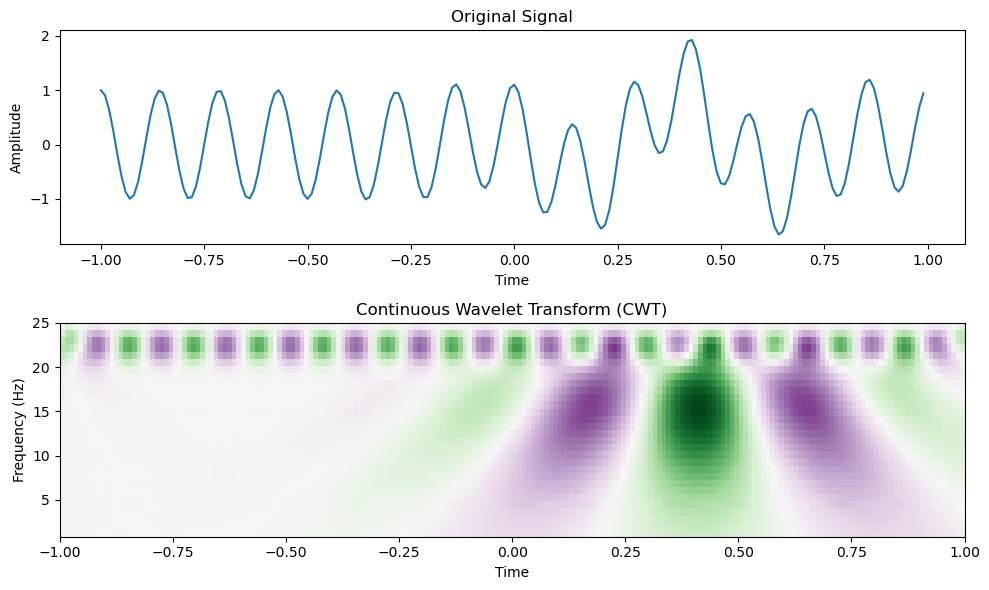

In [49]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Signal definition
t = np.linspace(-1, 1, 200, endpoint=False)
sig = np.cos(2 * np.pi * 7 * t) + np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.pi*2*(t-0.4)))

# Scales for CWT
widths = np.arange(1, 31)

# Perform CWT
cwtmatr, _ = pywt.cwt(sig, widths, 'mexh')

# Convert scales to frequencies
dt = t[1] - t[0]  # Sampling period
freqs = pywt.scale2frequency('mexh', widths) / dt

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Plot original signal
ax[0].plot(t, sig)
ax[0].set_title('Original Signal')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')

# Plot CWT using actual frequencies
extent = [-1, 1, freqs[-1], freqs[0]]  # Note the inversion of frequency limits
ax[1].imshow(cwtmatr, extent=extent, cmap='PRGn', aspect='auto',
             vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
ax[1].set_title('Continuous Wavelet Transform (CWT)')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import sounddevice as sd

# Assuming `cwtmatr` is the result from your CWT, and `freqs` contains the corresponding frequencies
# Let's consider `cwtmatr` as already computed, with time `t` and frequencies `freqs`

# Parameters
Fs = 44100  # Sampling Frequency for audio
duration = t[-1]  # Total duration of the sound

# Initialize the sound array
sound = np.zeros(int(duration * Fs))

# Iterate over the CWT result to generate sound
for i, freq in enumerate(freqs):
    for j, time in enumerate(t):
        # Get amplitude from CWT magnitude (you might want to scale or transform this)
        amplitude = abs(cwtmatr[i, j])
        
        # Generate a sine wave for this frequency and time
        samples = np.arange(time * Fs, (time + 1/Fs) * Fs)
        sine_wave = amplitude * np.sin(30*2 * np.pi * freq * samples / Fs)

        # Add or superimpose this sine wave onto the sound array
        sound[:len(sine_wave)] += sine_wave

# Normalize the sound (to avoid clipping)
sound = sound / np.max(np.abs(sound))

# Play the sound
sd.play(sound, Fs)
sd.wait()  # Wait until the sound is done playing


## Convert frequencies to MIDI note numbers
From Audio (wav) format to a symbolic format (MIDI). This step can be done in many ways. Symbolic format like MIDI can be processed quickly, especially after extracting MIDI attributes. 

We first calculate the MIDI note numbers from the peak_frequencies array using the [formula](https://en.wikipedia.org/wiki/MIDI_tuning_standard), which converts frequency in Hertz to a MIDI note number. We use a scaliing coefficient to convert seismic frequency to audiable signal. MIDI note numbers are integer numbers. We use np.ceil to round up to the nearest whole number and then cast the result to integers with .astype(int). The same type casting is done for the loudness to ensure MIDI compatibility. The loudness is calculated by finding the maximum amplitude of the spectrogram at each time slice, normalizing it against the highest amplitude in the entire spectrogram, and scaling it to fit into the MIDI velocity range, which is 0 to 127.

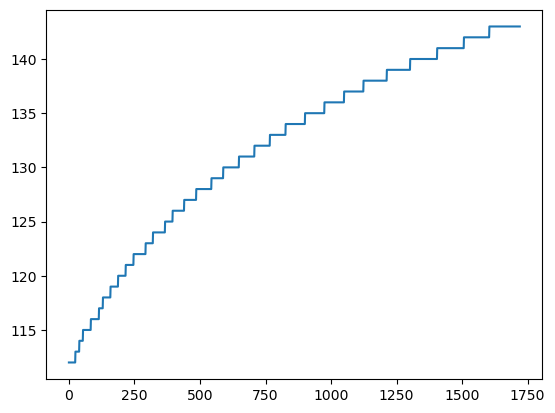

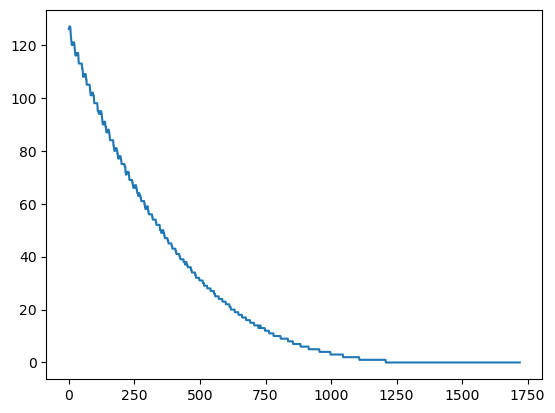

In [44]:
import numpy as np

# Scaling frequency coefficient to get audible signal 
FreqCoeff = 20

# Calculate MIDI notes from the peak frequencies
midi_notes = np.ceil(58 + 12 * np.log2(FreqCoeff * peak_frequencies / 440)).astype(int)

plt.figure
plt.plot(midi_notes)
plt.show()

# Initialize matrix:
N = len(midi_notes)  # Number of notes

# Calculate the loudness ('velocity') of the signal normalized in range 0 to 127
# The velocity is proportional to the maximum amplitude of the spectrogram
loudness = (127 * np.max(np.abs(Sxx), axis=0) / np.max(np.abs(Sxx))).astype(int)

plt.figure
plt.plot(loudness)
plt.show()

## Make a MIDI structure and write audio file on disk

To create a MIDI file, you'll need the mido library, which is a Python library for working with MIDI messages and files. If you don't have it installed, you can install it via 'conda install -c conda-forge mido'. This script will create a MIDI file where each note starts every 0.1 seconds (controlled by time_step) and lasts for 0.15 seconds (150 milliseconds).
We first initialize a MIDI file (MidiFile) and a MIDI track (MidiTrack), then iterate over the number of notes (N), and for each note:
- Create a 'note on' message with the calculated MIDI note number and loudness.
- Create a corresponding 'note off' message with a time difference to determine the note duration.
- Append these messages to the track.
- Save the track to a MIDI file ('AudioSeismogram-1.mid').

The time parameter in mido is a delta time, representing the time since the last message, in milliseconds. 

In [46]:
import mido
from mido import MidiFile, MidiTrack, Message, MAX_PITCHWHEEL
import sys
# Number of notes
N = len(midi_notes)
# Initialize MIDI track with note messages
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)
ticks_per_expr = 20
# Time step in seconds for the notes (start time for each note)
time_step = 100
track.append(Message('program_change', program=10))
# Adding notes to the MIDI track
for i in range(N):
    track.append(Message('note_on', note=midi_notes[i].astype(int), velocity=loudness[i], time=time_step))
    for j in range(time_step // ticks_per_expr):
        pitch = MAX_PITCHWHEEL * j * ticks_per_expr // time_step
        track.append(Message('pitchwheel', pitch=pitch, time=ticks_per_expr))
    track.append(Message('note_off', note=midi_notes[i].astype(int), velocity=loudness[i], time=0))
# Write MIDI file to disk
mid.save('AudioSeismogram-1.mid')

ValueError: data byte must be in range 0..127

##  Plot and play sonified seismic trace

- Define a function midi_to_audio that uses pretty_midi to convert MIDI data to an audio waveform.
- Play the converted audio using sounddevice.
- Create a figure window and plots the data, instantaneous spectrum, and sound amplitude in a loop.
- Update the plots with a vertical line that moves across the plot to indicate the current time point.
- Use plt.pause(0.02) to give an illusion of animation as it progresses through the loop.



In [8]:
import sounddevice as sd
import pretty_midi


midi_data = pretty_midi.PrettyMIDI('AudioSeismogram-1.mid')
audio_data = midi_data.synthesize(fs=Fs * FreqCoeff)

# Play the audio
sd.play(audio_data, Fs * FreqCoeff)

(0.0, 20.0)

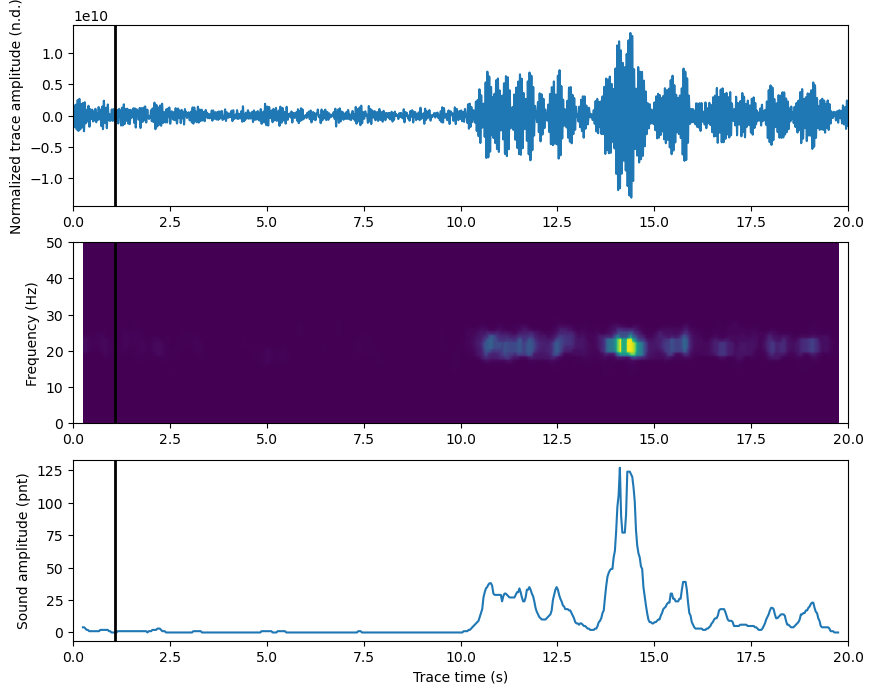

In [17]:
# Create and maximize figure window
plt.figure(figsize=(10, 8))

# Iterating through each note
# for it in range(N):
# Plot the signal
plt.subplot(3, 1, 1)
plt.plot(t, X)
plt.axvline(x=times[it], color='k', linewidth=2)
plt.ylabel('Normalized trace amplitude (n.d.)')
plt.xlim([0,20])
# Instantaneous spectrum plot
plt.subplot(3, 1, 2)
plt.imshow(abs(Sxx), aspect='auto', origin='lower', extent=[times.min(), times.max(), frequencies.min(), frequencies.max()])
plt.axvline(x=times[it], color='k', linewidth=2)
plt.ylim([0, 50])
plt.ylabel('Frequency (Hz)')
plt.xlim([0,20])
# Plot sound amplitude
plt.subplot(3, 1, 3)
plt.plot(times, loudness)
plt.axvline(x=times[it], color='k', linewidth=2)
plt.xlabel('Trace time (s)')
plt.ylabel('Sound amplitude (pnt)')
plt.xlim([0,20])
# Draw and pause
#plt.draw()
#plt.pause(0.02)

# Clear the figure for the next iteration
#plt.clf()

# Stop audio playback
sd.stop()

## Conclusions

In this example, we converted to sound a seismic trace extracted from an ocean bottom seismic record. The following steps are required:
- Data import to get a time series 
- Pre-processing to extract useful signal
- Calculate 2-D time-frequency spectrum using a Short-Time Fourier Transform (or other method of Time-Frequency analysis)
- Extract instantaneous peak frequency for each time slice using the time-frequency spectrum
- Convert instantaneous frequencies to MIDI notes
- Create MIDI structure and export and *.mid* file
- Create audio-synchronized animation and analyse the relation between the signal and its sonic representation. 